<a href="https://colab.research.google.com/github/yuanic/msba/blob/master/BAX_452_Beyond_Designations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Get Data

### 1.0 Pre Set Up: Installing Libraries

In [0]:
!pip -q install -U textblob

In [78]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from textblob import TextBlob
import urllib.request
from bs4 import BeautifulSoup
import nltk
nltk.download('punkt')
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
nltk.download('stopwords')
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.metrics import confusion_matrix
from PIL import Image
from urllib.request import urlopen

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### 1.1 Get Initial List of Postings

In [0]:
postings = pd.read_csv("https://raw.githubusercontent.com/yuanic/beyond_designations/master/indeed_job_url.csv")

In [80]:
postings.head()

,Company,JobID,Published Title,Inferred Title,Known Name
0,Hired,7a3af8c40410263b,Business Intelligence Analyst,Business Intelligence,N
1,Sound Physicians,7d2b26d7d1ff22d2,"Senior Analyst, Business Intelligence & Analytics",Business Intelligence,N
2,Skillz Inc.,04b53a5dc7cfe058,Business Intelligence Analyst,Business Intelligence,N
3,Uber,a30d683bba2b43f6,Business Intelligence Analyst,Business Intelligence,Y
4,Dolls Kill,d8c8fd8bf063435e,BI Analyst,Business Intelligence,N


In [81]:
len(postings)

394

![indeed_where_we_get_out_data](https://github.com/yuanic/beyond_designations/blob/master/data_source_description.png?raw=true/)

### 1.2 Scraping Indeed Website

In [89]:
%time
company_name = []
job_description = []


## get data loop through postings
for i in range(0,len(postings),1):
#for i in range(0,5,1):

  try:
    company=postings['Company'][i]
    target_url="https://www.indeed.com/viewjob?jk="+postings['JobID'][i]+"&tk=1d4gjl7v4bhot805&from=serp&vjs=3"
    page = urllib.request.urlopen(target_url) #For python 3 use urllib.request.urlopen(target_url)
    soup = BeautifulSoup(page)
    text = soup.find_all("div", attrs={"jobsearch-JobComponent-description"})[0].getText()
    company_name.append(company)
    job_description.append(text)
  except:
    print(target_url)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.44 µs


![indeed_data_scraping_selecting_description_method](https://github.com/yuanic/beyond_designations/blob/master/data_source_scraping_mtd.png?raw=true)





In [0]:
df_name = pd.DataFrame(company_name)
df_job = pd.DataFrame(job_description)
data = pd.concat([df_name,df_job],axis=1)
data = pd.concat([data,postings[['JobID', 'Published Title', 'Inferred Title', 'Known Name']]],axis=1)
data.columns = ['Company','Job_Description','JobID','Published_Title','Inferred_Title','Known_Name']

In [91]:
data.head()

,Company,Job_Description,JobID,Published_Title,Inferred_Title,Known_Name
0,Hired,We're on a mission to help get everyone a job ...,7a3af8c40410263b,Business Intelligence Analyst,Business Intelligence,N
1,Sound Physicians,"POSITION SUMMARY: Analysis, data modeling, and...",7d2b26d7d1ff22d2,"Senior Analyst, Business Intelligence & Analytics",Business Intelligence,N
2,Skillz Inc.,"About Skillz:\nToday, people spend more time p...",04b53a5dc7cfe058,Business Intelligence Analyst,Business Intelligence,N
3,Uber,"At Uber, we ignite opportunity by setting the ...",a30d683bba2b43f6,Business Intelligence Analyst,Business Intelligence,Y
4,Dolls Kill,About Us\nNamed “The Fastest Growing Retailer ...,d8c8fd8bf063435e,BI Analyst,Business Intelligence,N


In [0]:
data['Job_Description'] = data['Job_Description'].replace("\n", " ", regex=True)
data['Job_Description'] = data['Job_Description'].replace("'\'", ' ', regex=True) 
data['Job_Description'] = data['Job_Description'].astype(str)
data['Job_Description'] = data['Job_Description'].map(lambda x: x.lower())
data['JD_Tokenized']=data['Job_Description'].apply(word_tokenize,0)
data['JD_Word_Cnt']=data['JD_Tokenized'].apply(len,0)

In [93]:
data.head()

,Company,Job_Description,JobID,Published_Title,Inferred_Title,Known_Name,JD_Tokenized,JD_Word_Cnt
0,Hired,we're on a mission to help get everyone a job ...,7a3af8c40410263b,Business Intelligence Analyst,Business Intelligence,N,"[we, 're, on, a, mission, to, help, get, every...",560
1,Sound Physicians,"position summary: analysis, data modeling, and...",7d2b26d7d1ff22d2,"Senior Analyst, Business Intelligence & Analytics",Business Intelligence,N,"[position, summary, :, analysis, ,, data, mode...",734
2,Skillz Inc.,"about skillz: today, people spend more time pl...",04b53a5dc7cfe058,Business Intelligence Analyst,Business Intelligence,N,"[about, skillz, :, today, ,, people, spend, mo...",842
3,Uber,"at uber, we ignite opportunity by setting the ...",a30d683bba2b43f6,Business Intelligence Analyst,Business Intelligence,Y,"[at, uber, ,, we, ignite, opportunity, by, set...",518
4,Dolls Kill,about us named “the fastest growing retailer i...,d8c8fd8bf063435e,BI Analyst,Business Intelligence,N,"[about, us, named, “, the, fastest, growing, r...",407


In [94]:
## if number of rows before and after droping "NA' is 0, all job postings are still relevant. 
## if not, create a new list or change source to the saved csv file done in section 1.3 previously
len(postings[['Company', 'JobID', 'Published Title', 'Inferred Title', 'Known Name']].dropna())

394

### 1.3 Saving Copy of Job Description before posting expires

In [0]:
#from google.colab import drive
#drive.mount('drive')

In [0]:
#%cd './drive/My Drive/Colab Notebooks/BAX 452 - Machine Learning Final Project'

In [0]:
#data.to_csv('job_descriptions_20190227.csv')

## 2. Explore Data

### 2.1 How many characters are there in a job posting?

In [98]:
from nltk.probability import ConditionalFreqDist
from nltk.probability import ConditionalProbDist, ELEProbDist
data_all_raw = word_tokenize(', '.join(data['Job_Description']))
cfdist = nltk.probability.FreqDist(data_all_raw)
cfdist.most_common(10)

[(',', 15025),
 ('and', 12163),
 ('.', 6911),
 ('to', 6800),
 ('the', 5613),
 ('of', 4127),
 ('--', 4087),
 ('a', 3613),
 ('in', 3289),
 ('with', 3192)]

In [0]:
## punctuations stopwrods
stop_words_PUNC = []
stop_words_PUNC.append(',')
stop_words_PUNC.append('.')
stop_words_PUNC.append('--')
stop_words_PUNC.append('(')
stop_words_PUNC.append(')')
stop_words_PUNC.append(':')
stop_words_PUNC.append('’')
stop_words_PUNC.append('&')
stop_words_PUNC.append('’')
stop_words_PUNC.append('-')
stop_words_PUNC.append('/')

In [0]:
def remove_PUNC_stopwords (x):
  w_filtered = [w for w in x if not w in stop_words_PUNC]
  return w_filtered

In [0]:
data['JD_Tokenized_minus_PUNC'] = data['JD_Tokenized'].apply(remove_PUNC_stopwords,0)
data['cnt_JD_Tokenized_minus_PUNC'] = data['JD_Tokenized_minus_PUNC'].apply(len,0)
data['cnt_JD_Tokenized_minus_PUNC']=pd.to_numeric(data['cnt_JD_Tokenized_minus_PUNC'])

In [0]:
data['cnt_JD_Tokenized_minus_PUNC']=pd.to_numeric(data['cnt_JD_Tokenized_minus_PUNC'])

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


Text(0, 0.5, 'Count of Job Listings')

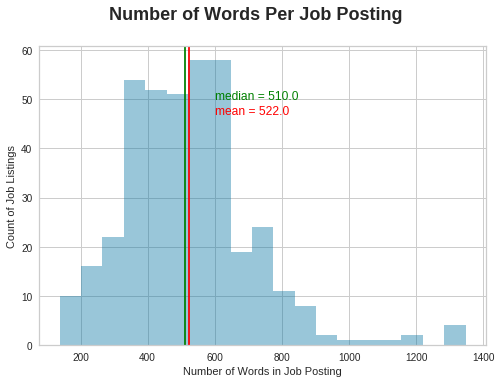

In [103]:
fig = plt.figure()
sns.distplot(data['cnt_JD_Tokenized_minus_PUNC'],kde=False)
my_median = np.median(data['cnt_JD_Tokenized_minus_PUNC'])
my_mean = np.mean(data['cnt_JD_Tokenized_minus_PUNC'])
plt.axvline(my_median, 0,1,color='green')
plt.axvline(my_mean, 0,1,color='red')
plt.text(600,50,"median = " + str(my_median),rotation=0,color='green')
plt.text(600,47,"mean = " + str(round(my_mean,0)),rotation=0,color='red')
fig.suptitle('Number of Words Per Job Posting',size=18,fontweight='bold')
plt.xlabel('Number of Words in Job Posting')
plt.ylabel('Count of Job Listings')

### 2.2 What is the impact of English Stop Words?

In [104]:
## english stopwrods
stop_words = nltk.corpus.stopwords.words('english')
len(stop_words)

179

In [0]:
def remove_ENG_stopwords (x):
  w_filtered = [w for w in x if not w in stop_words]
  return w_filtered

In [0]:
data['JD_Tokenized_minus_ENG'] = data['JD_Tokenized_minus_PUNC'].apply(remove_ENG_stopwords,0)
data['cnt_JD_Tokenized_minus_ENG'] = data['JD_Tokenized_minus_ENG'].apply(len,0)
data['cnt_JD_Tokenized_minus_ENG']=pd.to_numeric(data['cnt_JD_Tokenized_minus_ENG'])

In [107]:
my_tokens_minus_ENG = []
def merge_tokens(x):
  for line in x:
    for w in line:
      my_tokens_minus_ENG.append(w)
merge_tokens(data['JD_Tokenized_minus_ENG'])
cfdist_minus_ENG = nltk.probability.FreqDist(my_tokens_minus_ENG)
cfdist_minus_ENG.most_common(10)

[('data', 3103),
 ('experience', 1810),
 ('business', 1666),
 ('product', 1331),
 ('team', 1099),
 ('work', 959),
 ('analytics', 759),
 ('skills', 707),
 ('marketing', 627),
 ('ability', 567)]

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


Text(0, 0.5, 'Count of Job Listings')

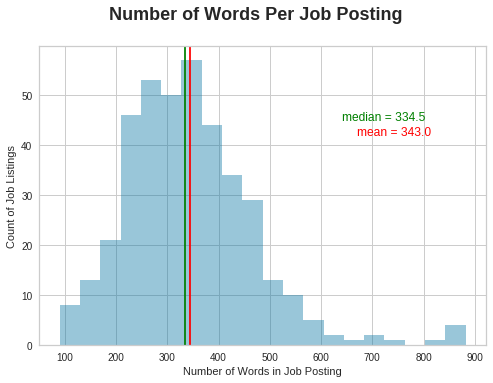

In [108]:
fig = plt.figure()
sns.distplot(data['cnt_JD_Tokenized_minus_ENG'],kde=False)
median_word_cnt = np.median(data['cnt_JD_Tokenized_minus_ENG'])
mean_word_cnt = np.mean(data['cnt_JD_Tokenized_minus_ENG'])
plt.axvline(median_word_cnt, 0,1,color='green')
plt.axvline(mean_word_cnt, 0,1,color='red')
plt.text(640,45,"median = " + str(median_word_cnt),rotation=0,color='green')
plt.text(670,42,"mean = " + str(round(mean_word_cnt,0)),rotation=0,color='red')
fig.suptitle('Number of Words Per Job Posting',size=18,fontweight='bold')
plt.xlabel('Number of Words in Job Posting')
plt.ylabel('Count of Job Listings')

In [0]:
## % ENG Stop Words (of all minus PUNC)
data['perc_ENG_stopwords'] = 1-np.divide(data['cnt_JD_Tokenized_minus_ENG'],data['cnt_JD_Tokenized_minus_PUNC'])

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


Text(0, 0.5, 'Count of Job Listings')

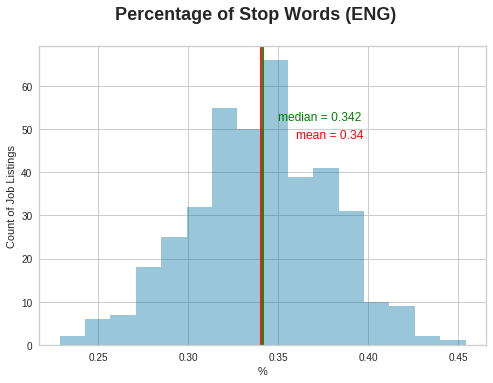

In [110]:
fig = plt.figure()
sns.distplot(data['perc_ENG_stopwords'],kde=False)
my_median = np.median(data['perc_ENG_stopwords'])
my_mean = np.mean(data['perc_ENG_stopwords'])
plt.axvline(my_median, 0,1,color='green')
plt.axvline(my_mean, 0,1,color='red')
plt.text(0.35,52,"median = " + str(round(my_median,3)),rotation=0,color='green')
plt.text(0.36,48,"mean = " + str(round(my_mean,3)),rotation=0,color='red')
fig.suptitle('Percentage of Stop Words (ENG)',size=18,fontweight='bold')
plt.xlabel('%')
plt.ylabel('Count of Job Listings')

In [111]:
data.sort_values('perc_ENG_stopwords',ascending=False).head()

,Company,Job_Description,JobID,Published_Title,Inferred_Title,Known_Name,JD_Tokenized,JD_Word_Cnt,JD_Tokenized_minus_PUNC,cnt_JD_Tokenized_minus_PUNC,JD_Tokenized_minus_ENG,cnt_JD_Tokenized_minus_ENG,perc_ENG_stopwords
393,Verve,is playing with data and teaching business sta...,b6e895eb34d2b5b0,Business Intelligence Analyst,Business Intelligence,N,"[is, playing, with, data, and, teaching, busin...",678,"[is, playing, with, data, and, teaching, busin...",621,"[playing, data, teaching, business, stakeholde...",339,0.454106
146,Thorn,thorn is a non-profit focused on building tech...,231feffbbeca1500,Data Scientist,Data Scientist,N,"[thorn, is, a, non-profit, focused, on, buildi...",483,"[thorn, is, a, non-profit, focused, on, buildi...",432,"[thorn, non-profit, focused, building, technol...",245,0.432870
54,Scoot Network,scoot’s mission is electric vehicles for every...,f769f249a3a38b81,Data Analyst,Data Analyst,N,"[scoot, ’, s, mission, is, electric, vehicles,...",483,"[scoot, s, mission, is, electric, vehicles, fo...",424,"[scoot, mission, electric, vehicles, everyone,...",243,0.426887
74,Atlassian,atlassian is looking for a data engineer to jo...,d4e8037d3e06691b,Data Engineer,Data Engineer,Y,"[atlassian, is, looking, for, a, data, enginee...",913,"[atlassian, is, looking, for, a, data, enginee...",811,"[atlassian, looking, data, engineer, join, dat...",466,0.425401
212,ReferralExchange,"$90,000 - $120,000 a yeardo you understand wha...",7ec9bf06bb535cf0,Product Manager,Product Manager,N,"[$, 90,000, -, $, 120,000, a, yeardo, you, und...",664,"[$, 90,000, $, 120,000, a, yeardo, you, unders...",610,"[$, 90,000, $, 120,000, yeardo, understand, ta...",352,0.422951


### 2.3 What is the impact of Data Stopwords?

In [115]:
## data stopwords
stop_words_data = []
for w in data['Company']:
  stop_words_data.append(w.lower())
for w in data['Inferred_Title']:
  w_tokens = word_tokenize(w)
  for token in w_tokens:
    stop_words_data.append(token.lower())
stop_words_data = set(stop_words_data)
len(stop_words_data)

289

In [0]:
def remove_DATA_stopwords (x):
  w_filtered = [w for w in x if not w in stop_words_data]
  return w_filtered

In [0]:
data['JD_Tokenized_minus_DATA'] = data['JD_Tokenized_minus_ENG'].apply(remove_DATA_stopwords,0)

In [0]:
data['cnt_JD_Tokenized_minus_DATA'] = data['JD_Tokenized_minus_DATA'].apply(len,0)
data['cnt_JD_Tokenized_minus_DATA']=pd.to_numeric(data['cnt_JD_Tokenized_minus_DATA'])

In [119]:
my_tokens_minus_DATA = []
def merge_tokens_data(x):
  for line in x:
    for w in line:
      my_tokens_minus_DATA.append(w)
merge_tokens_data(data['JD_Tokenized_minus_DATA'])
cfdist_minus_DATA = nltk.probability.FreqDist(my_tokens_minus_DATA)
cfdist_minus_DATA.most_common(20)

[('experience', 1810),
 ('team', 1099),
 ('work', 959),
 ('skills', 707),
 ('ability', 567),
 ('teams', 553),
 ('analysis', 547),
 ('years', 529),
 ('strong', 505),
 ('help', 478),
 ('insights', 475),
 ('company', 468),
 ('new', 464),
 ('role', 456),
 ('working', 440),
 ('management', 440),
 ('tools', 426),
 ('customer', 426),
 ('across', 421),
 ('build', 412)]

In [0]:
## % DATA Stop Words (of ENG)
data['perc_DATA_stopwords'] = 1-np.divide(data['cnt_JD_Tokenized_minus_DATA'],data['cnt_JD_Tokenized_minus_ENG'])

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


Text(0, 0.5, 'Count of Job Listings')

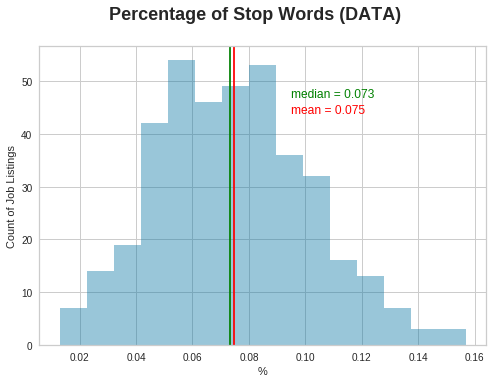

In [121]:
fig = plt.figure()
sns.distplot(data['perc_DATA_stopwords'],kde=False)
my_median = np.median(data['perc_DATA_stopwords'])
my_mean = np.mean(data['perc_DATA_stopwords'])
plt.axvline(my_median, 0,1,color='green')
plt.axvline(my_mean, 0,1,color='red')
plt.text(0.095,47,"median = " + str(round(my_median,3)),rotation=0,color='green')
plt.text(0.095,44,"mean = " + str(round(my_mean,3)),rotation=0,color='red')
fig.suptitle('Percentage of Stop Words (DATA)',size=18,fontweight='bold')
plt.xlabel('%')
plt.ylabel('Count of Job Listings')

### 2.4 What are the Professions we are considering (Inferred Titles)?

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


(array([ 0., 10., 20., 30., 40., 50., 60., 70., 80.]),
 <a list of 9 Text yticklabel objects>)

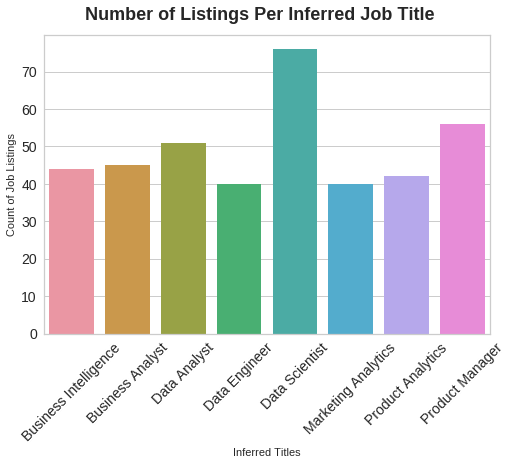

In [122]:
fig = plt.figure()
sns.countplot(x='Inferred_Title',data=data)
fig.suptitle('Number of Listings Per Inferred Job Title',size=18,fontweight='bold',y='0.95')
plt.xlabel('Inferred Titles')
plt.xticks(rotation=45,fontsize=14)
plt.ylabel('Count of Job Listings')
plt.yticks(fontsize=14)


In [123]:
## Viz
!pip install ggplot
from ggplot import *

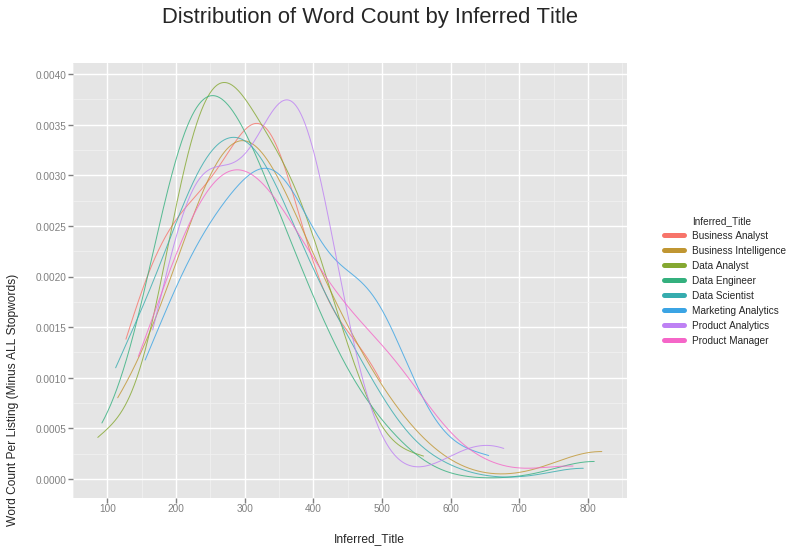

<ggplot: (8785850254056)>

In [124]:
ggplot(data, aes(x='cnt_JD_Tokenized_minus_DATA', color='Inferred_Title')) +\
    geom_density(alpha=0.8) +\
    xlab("Inferred_Title") +\
    ylab("Word Count Per Listing (Minus ALL Stopwords)") +\
    ggtitle(element_text(text='Distribution of Word Count by Inferred Title', size=22))

### 2.5 Word Clouds by Inferred Title

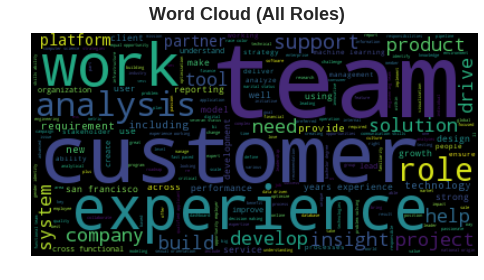

In [125]:
## customer, team, experience, analysis. Consider if experience here means working experience of customer experience
data_wordcloud = nltk.Text(my_tokens_minus_DATA)

fig = plt.figure()
fig.suptitle('Word Cloud (All Roles)',size=18,fontweight='bold',y='0.85')
wordcloud = WordCloud().generate(' '.join(data_wordcloud))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show() 

In [0]:
def word_cloud_generate(x):
  word_cloud_text = []
  def merge_word_cloud_text(x):
    for line in x:
      for w in line:
        word_cloud_text.append(w)
  merge_word_cloud_text(data[data['Inferred_Title']==x]['JD_Tokenized_minus_DATA'])

  wordcloud = WordCloud().generate(' '.join(word_cloud_text))
  fig = plt.figure()
  fig.suptitle(x,size=18,fontweight='bold',y=0.85)
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis("off")
  plt.show()

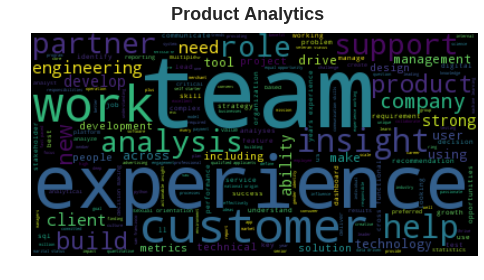

In [0]:
word_cloud_generate('Product Analytics') ## customer focused, insight

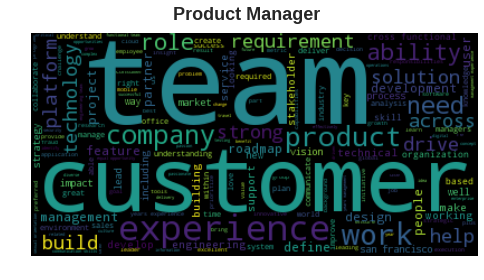

In [0]:
word_cloud_generate('Product Manager') ## even more team and customer focusd. product manager drive, product analytics support (insights)

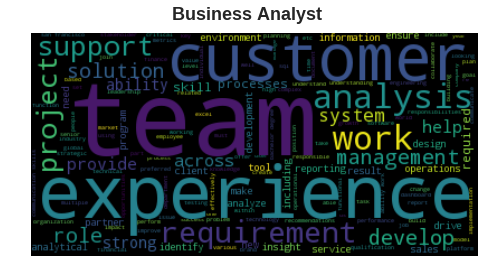

In [0]:
word_cloud_generate('Business Analyst') # analysisi, support, project based

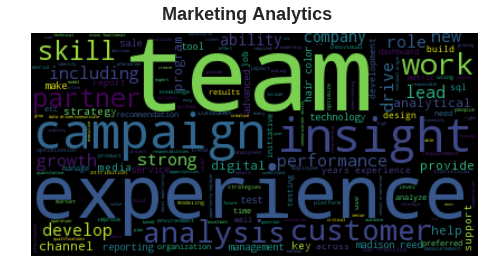

In [0]:
word_cloud_generate('Marketing Analytics') ## campaign focusesd

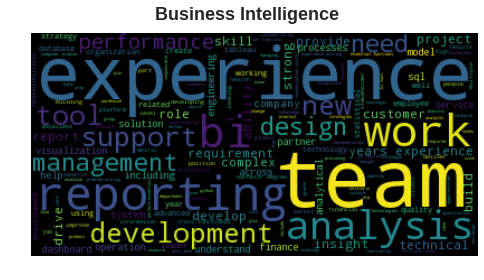

In [0]:
word_cloud_generate('Business Intelligence') ## reporting focused

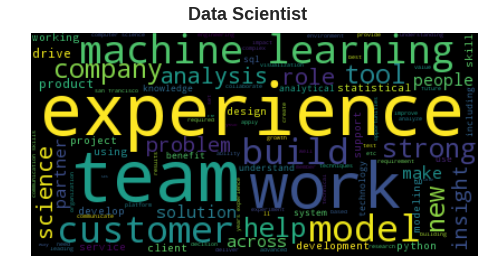

In [0]:

word_cloud_generate('Data Scientist') ## machinese learning, model, build, new?

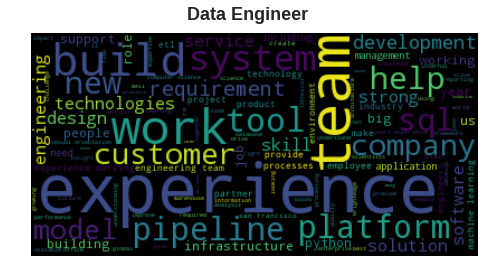

In [0]:
word_cloud_generate('Data Engineer') ## pipeline, tool, system, only sql shows up here? new?

### 2.5 What are Companies Like?

In [126]:
## which companies have represented multiple times in our dataset?
top_represented_companies = pd.DataFrame(data.groupby('Company').count().sort_values('JobID',ascending=False)['JobID'].head()).reset_index()
top_represented_companies.columns = ['Company',"No.Listings"]
top_represented_companies

,Company,No.Listings
0,Google,8
1,Uber,8
2,Amazon,7
3,Twitter,7
4,Autodesk,6


In [0]:
## create function to create word cloud for coompanies
def word_cloud_generate_company(x):
  word_cloud_text = []
  def merge_word_cloud_text(x):
    for line in x:
      for w in line:
        word_cloud_text.append(w)
  merge_word_cloud_text(data[data['Company']==x]['JD_Tokenized_minus_DATA'])

  wordcloud = WordCloud(background_color="white", mode="RGBA",mask=mask).generate(' '.join(word_cloud_text))
  wc = WordCloud(
    background_color="white",
    max_words=2000,
    mask=mask,
    stopwords=STOPWORDS,
    )

  # create coloring from image
  image_colors = ImageColorGenerator(mask)
  plt.figure(figsize=[7,7])
  plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear")

  plt.axis("off")

  plt.show()


![Google](https://raw.githubusercontent.com/yuanic/beyond_designations/master/GOOGLE.jpg)

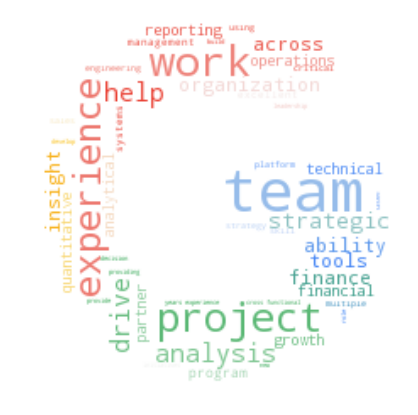

In [0]:
## google project driven
mask = np.array(Image.open(urlopen('https://raw.githubusercontent.com/yuanic/beyond_designations/master/GOOGLE.jpg')))
word_cloud_generate_company('Google')

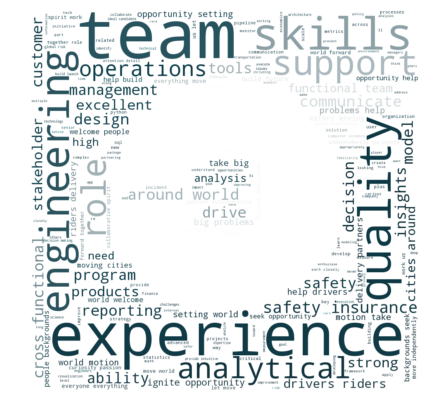

In [129]:
## uber quality
mask = np.array(Image.open(urlopen('https://raw.githubusercontent.com/yuanic/beyond_designations/master/UBER10.jpeg')))
word_cloud_generate_company('Uber')

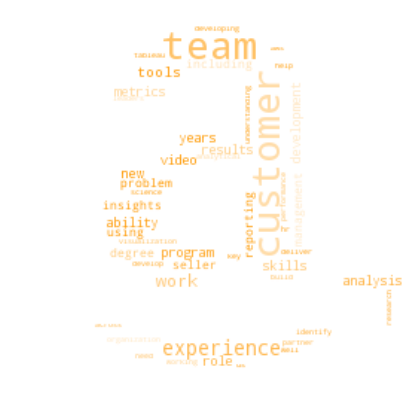

In [0]:
## amazon customer focused
mask = np.array(Image.open(urlopen('https://raw.githubusercontent.com/yuanic/beyond_designations/master/AMAZON.jpg')))
word_cloud_generate_company('Amazon')

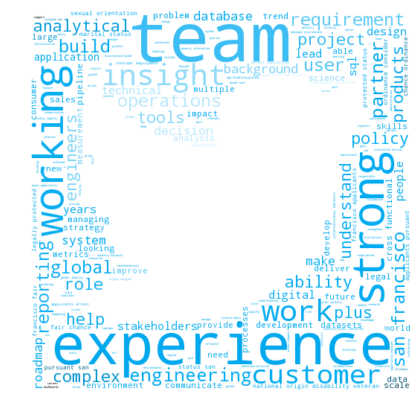

In [0]:
## Twitter is looking for insights
mask = np.array(Image.open(urlopen('https://raw.githubusercontent.com/yuanic/beyond_designations/master/TWITTER4.png')))
word_cloud_generate_company('Twitter')

## 3. Feature Engineering

### 3.1 TFID Vectorization

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer
data['Final_JD']=nltk.Text(data['JD_Tokenized_minus_ENG'])
v = TfidfVectorizer()
X = v.fit_transform(data['Final_JD'].astype(str))
X_dense = X.toarray()

### 3.2 PCA Decomposition

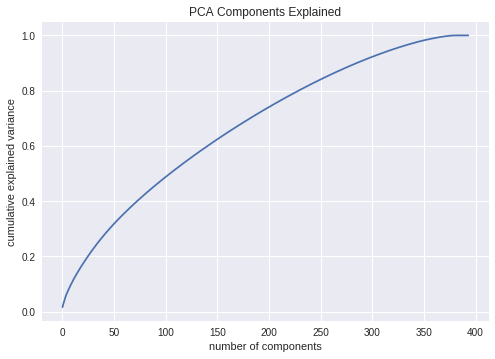

In [0]:
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(X_dense)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.title('PCA Components Explained');

In [0]:
pca.n_components = 350
X_reduced = pca.fit_transform(X_dense)
X_reduced.shape

(394, 350)

## 4. Modeling: Classification

### 4.1 Classification: Random Forest Classifier

In [0]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score,train_test_split
from sklearn.preprocessing import StandardScaler

#Train and Test splitting of data
X = X_reduced
y = data['Inferred_Title']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42,stratify=y)

t_ntrees = []
t_depth =[]
t_accuracy=[]


for n_trees in range(1, 50, 1):
    for depth in range(1, 10, 1):
        model = RandomForestClassifier(n_estimators = n_trees, max_depth = depth, random_state=50)
        scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
        t_ntrees.append(n_trees)
        t_depth.append(depth)
        t_accuracy.append(scores.mean())

output1 = pd.DataFrame.from_dict(t_ntrees)
output2 = pd.DataFrame.from_dict(t_depth)
output3 = pd.DataFrame.from_dict(t_accuracy)
output1.columns=['ntrees']
output2.columns=['depth']
output3.columns=['accuracy']
output = output1.join(output2).join(output3)
output.sort_values(['accuracy'],ascending=False).head()

,ntrees,depth,accuracy
383,43,6,0.496602
430,48,8,0.496403
377,42,9,0.493078
392,44,6,0.492829
310,35,5,0.492260


In [0]:
model1 = RandomForestClassifier(n_estimators = 43, max_depth=6, random_state=50)
model1.fit(X_train, y_train)
scores = cross_val_score(model1, X_train, y_train, cv=5)
print('CV AUC {}, Average AUC {}'.format(scores, scores.mean()))

CV AUC [0.55932203 0.51785714 0.46428571 0.49056604 0.45098039], Average AUC 0.4966022641867748


(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5]),
 <a list of 8 Text yticklabel objects>)

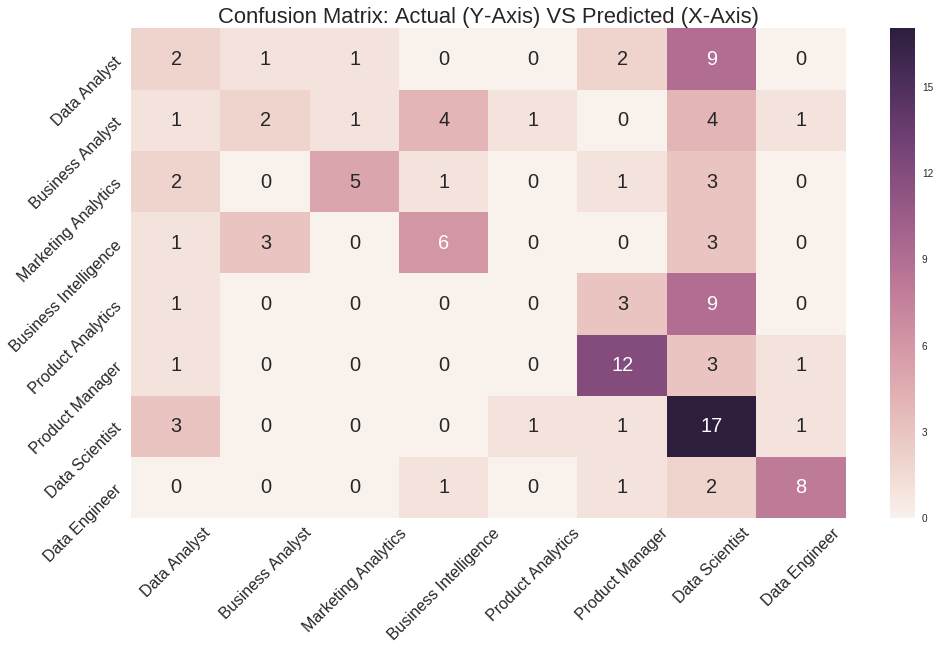

In [0]:
y_predicted = model1.predict(X_test)
f, ax = plt.subplots(1,1,figsize=(16,9))
sns.heatmap(confusion_matrix(y_test, y_predicted,labels=["Data Analyst","Business Analyst", "Marketing Analytics", "Business Intelligence","Product Analytics","Product Manager","Data Scientist","Data Engineer"]),annot=True,annot_kws={"size": 20})
ax.set_title('Confusion Matrix: Actual (Y-Axis) VS Predicted (X-Axis)', fontsize=22); 
ax.xaxis.set_ticklabels(["Data Analyst","Business Analyst", "Marketing Analytics", "Business Intelligence","Product Analytics","Product Manager","Data Scientist","Data Engineer"]); 
ax.yaxis.set_ticklabels(reversed(["Data Analyst","Business Analyst", "Marketing Analytics", "Business Intelligence","Product Analytics","Product Manager","Data Scientist","Data Engineer"]))
plt.xticks(rotation=45,fontsize=16)
plt.yticks(rotation=45,fontsize=16)



In [0]:
y1 = pd.DataFrame(y_test).reset_index()
y2 = pd.DataFrame(y_predicted).reset_index()
outcome = pd.concat([y1,y2],axis=1)
outcome.columns = ['Original_Posting_Index',"Actual_Inferred_Title","X2","Predicted_Inferred_Title"]
outcome = outcome[['Original_Posting_Index','Actual_Inferred_Title','Predicted_Inferred_Title']]
outcome[outcome['Actual_Inferred_Title']=='Data Analyst']

,Original_Posting_Index,Actual_Inferred_Title,Predicted_Inferred_Title
1,30,Data Analyst,Data Scientist
6,50,Data Analyst,Business Analyst
12,324,Data Analyst,Data Scientist
20,22,Data Analyst,Data Scientist
27,36,Data Analyst,Data Scientist
46,270,Data Analyst,Marketing Analytics
55,28,Data Analyst,Data Analyst
58,32,Data Analyst,Data Scientist
69,261,Data Analyst,Data Scientist
77,38,Data Analyst,Data Scientist


In [0]:
len(outcome[outcome['Actual_Inferred_Title']==outcome['Predicted_Inferred_Title']])/len(outcome)

0.4369747899159664

In [0]:
import textwrap
strs = data.iloc[30]['Job_Description']
print("Company: ", data.iloc[30]['Company'])
print("Company: ", data.iloc[30]['Published_Title'])
print("Company: ", data.iloc[30]['Inferred_Title'])
print(textwrap.fill(strs, 125))

Company:  Unify Conuslting
Company:  Data Analyst
Company:  Data Analyst
contractbuilding upon the momentum in seattle, unify consulting is rapidly expanding in the bay area.our business is growing,
and with the expansion comes an immediate need for building out our san francisco team. we are seeking both experienced
“senior consultant” level (4-7 years’ experience) and “manager/senior manager” level (8+ years) experience preferably who
have worked in consulting (management or technology) before who are versatile in skillset and are passionate about bringing
value to our clients. we look for technology, data and analytics leaders who are experts in their fields who also want to
make a meaningful impact for local clients in san francisco and the bay area.who you are: as a data driven insights
consultant, you seek the truth in data, whether that is creating models that answer complex business problems, analyzing data
to understand and unlock correlations and insights, or creating structu

### 4.2 Classification: K Nearest Neighbors

In [0]:
from sklearn.neighbors import KNeighborsClassifier

n_neighbors = []
n_accuracy = []

for k in range(1, 20, 1):
  model = KNeighborsClassifier(n_neighbors=k)
  scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
  n_neighbors.append(k)
  n_accuracy.append(scores.mean())

output1 = pd.DataFrame.from_dict(n_neighbors)
output2 = pd.DataFrame.from_dict(n_accuracy)
output1.columns=['n_neighbors']
output2.columns=['accuracy']
output = output1.join(output2)
output.sort_values(['accuracy'],ascending=False).head()



,n_neighbors,accuracy
17,18,0.568252
16,17,0.567835
14,15,0.561600
15,16,0.561418
18,19,0.556783


In [0]:
model2 = KNeighborsClassifier(n_neighbors=18)
model2.fit(X_train,y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=18, p=2,
           weights='uniform')

In [0]:
scores = cross_val_score(model2, X_train, y_train, cv=5)
print('CV AUC {}, Average AUC {}'.format(scores, scores.mean()))

CV AUC [0.57627119 0.51785714 0.5        0.69811321 0.54901961], Average AUC 0.5682522289376257


(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5]),
 <a list of 8 Text yticklabel objects>)

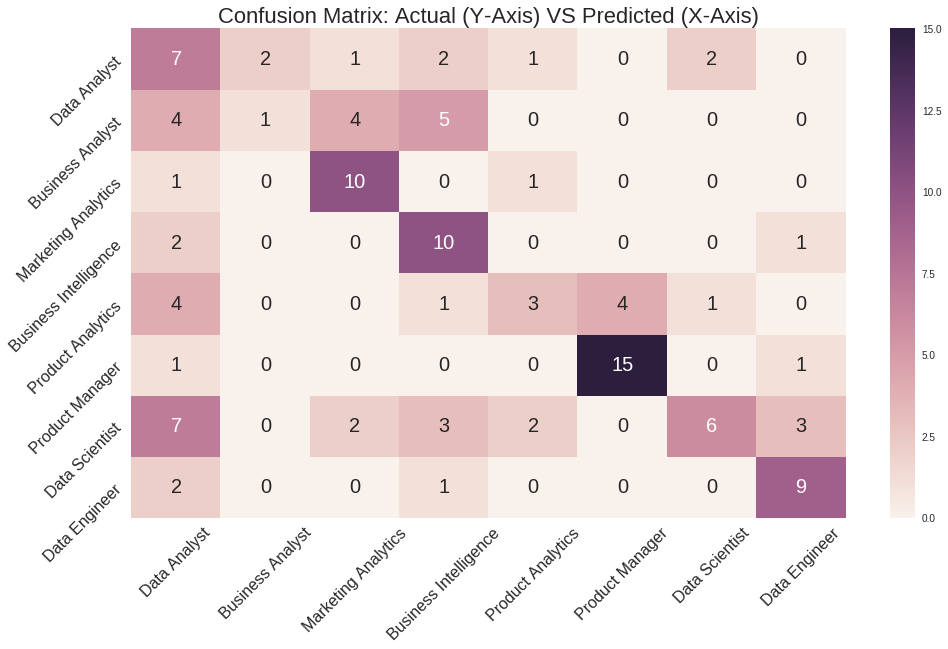

In [0]:
y_predicted = model2.predict(X_test)
f, ax = plt.subplots(1,1,figsize=(16,9))
sns.heatmap(confusion_matrix(y_test, y_predicted,labels=["Data Analyst","Business Analyst", "Marketing Analytics", "Business Intelligence","Product Analytics","Product Manager","Data Scientist","Data Engineer"]),annot=True,annot_kws={"size": 20})
ax.set_title('Confusion Matrix: Actual (Y-Axis) VS Predicted (X-Axis)', fontsize=22); 
ax.xaxis.set_ticklabels(["Data Analyst","Business Analyst", "Marketing Analytics", "Business Intelligence","Product Analytics","Product Manager","Data Scientist","Data Engineer"]); 
ax.yaxis.set_ticklabels(reversed(["Data Analyst","Business Analyst", "Marketing Analytics", "Business Intelligence","Product Analytics","Product Manager","Data Scientist","Data Engineer"]))
plt.xticks(rotation=45,fontsize=16)
plt.yticks(rotation=45,fontsize=16)

In [0]:
y1 = pd.DataFrame(y_test).reset_index()
y2 = pd.DataFrame(y_predicted).reset_index()
outcome = pd.concat([y1,y2],axis=1)
outcome.columns = ['Original_Posting_Index',"Actual_Inferred_Title","X2","Predicted_Inferred_Title"]
outcome = outcome[['Original_Posting_Index','Actual_Inferred_Title','Predicted_Inferred_Title']]
outcome[outcome['Actual_Inferred_Title']=='Data Analyst']

,Original_Posting_Index,Actual_Inferred_Title,Predicted_Inferred_Title
1,30,Data Analyst,Business Analyst
6,50,Data Analyst,Data Analyst
12,324,Data Analyst,Data Scientist
20,22,Data Analyst,Business Intelligence
27,36,Data Analyst,Data Analyst
46,270,Data Analyst,Marketing Analytics
55,28,Data Analyst,Data Analyst
58,32,Data Analyst,Business Intelligence
69,261,Data Analyst,Business Analyst
77,38,Data Analyst,Data Scientist


In [0]:
len(outcome[outcome['Actual_Inferred_Title']==outcome['Predicted_Inferred_Title']])/len(outcome)

0.5126050420168067

## 5. Modeling: Clustering

### 5.1 Clustering:  K-Means 

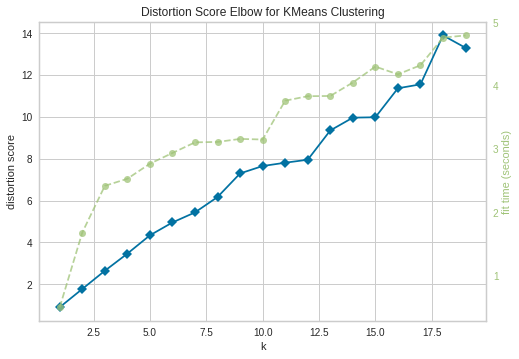

In [0]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,20))

visualizer.fit(X_dense)    # Fit the data to the visualizer
visualizer.poof()    # Draw/show/poof the data

### 5.2 Clustering: DB Scan

In [0]:
from sklearn.cluster import DBSCAN
DB =  DBSCAN()
y_DB = DB.fit_predict(X_dense)
np.unique(y_DB, return_counts=True)

(array([-1]), array([394]))

## 6. Conclusion


### 6.1 Machine Learning Key Takeaways



*  KNN Method was more effective in classifying the Job Listings (51.2% VS 43.6%)
*  Clustering however suggests that there is no significant similarities among the job postings, whether it is by role or company.
*  NLP is hard. We need to think about how we handle words and what context they are used in
*  Consider testing out different n-gram settings when vectorizing with TFID


### 6.2 Data & Python Learning Points


* Using Beautiful Soup to scrape the web
* Creating dunctions and loops for repititive tasks
* Creating "fancy" word clouds can by easy!



### 6.3 Beyond Designations

* Do not overlook a job just because of its title
* Hirnig companies should consider they better position themselves when attracting candidates